In [38]:
# =========================
# CONFIG — centralized settings for experiments and data
# Edit parameters here to control the entire notebook.
# =========================

CONFIG = {
    "model": {
        "learning_rate": 1e-3,        # Learning rate used by the optimizer (Adam by default)
        "epochs": 60,                  # Total number of training epochs for new training runs
        "batch_size": 64,
        "hidden_sizes": [64, 32],      # Sizes of hidden layers for the MLP
        "weight_decay": 0.0,           # L2 regularization (weight decay) strength
        "dropout": 0.0,
        "use_batchnorm": False,        # Whether to include BatchNorm layers in the MLP
        # Early stopping behavior
        "early_stopping": {
            "enabled": True,
            "patience": 15,            # stop if no validation improvement after this many epochs
            "min_delta": 1e-5          # minimum improvement to reset patience
        }
    },
    "data": {
        "data_csv": "houses.csv",      # Path to the CSV file containing the dataset
        "feature_cols": ["median_income", "housing_median_age", "total_rooms", "latitude", "longitude"], # predictor columns
        "target_col": "median_house_value",   # target column to predict
        "test_size": 0.10,             # final test set fraction
        "val_size": 0.22,              # validation fraction of remaining (after test split)
        "shuffle": True,               # shuffle before splitting
        "scaler": "standard",          # "standard" or "minmax"
        "log1p_features": ["total_rooms"],  # Apply log1p transform to selected features
        "sample_size": None
    },
    "random_seeds": {
        "python": 42,
        "numpy": 42,
        "torch": 42
    },
    "runtime": {
        "use_cuda_if_available": True  # If True, use CUDA when available (else fall back to CPU)
    },
    "evaluation": {
        "epochs_for_plots": 100,        # Epochs for learning-curve diagnostic run
        "plot_test_curve": True        # Also plot test loss curve
    },
    "hyperparam_search": {"n_trials": 30,},
    # Experiments: Each entry overrides BASELINE (name must be unique)
    # - "model": overrides for model config (e.g., hidden_sizes, dropout, use_batchnorm)
    # - "train": overrides for training (e.g., epochs, lr, batch_size, weight_decay, patience, name)
    # - "tfm":   overrides for transforms (e.g., log_total_rooms)
    "experiments": [
        {
            "name": "baseline",
            "model": {"hidden_sizes": [64, 32], "dropout": 0.0},
            "train": {"name": "baseline", "epochs": 100, "lr": 1e-3, "batch_size": 64, "weight_decay": 0.0, "patience": 15},
            "tfm":   {"log_total_rooms": False}
        },
        {
            "name": "epochs_x2",
            "model": {},
            "train": {"name": "epochs_x2", "epochs": 200},
            "tfm":   {}
        },
        {
            "name": "log1p_total_rooms",
            "model": {},
            "train": {"name": "log1p_total_rooms"},
            "tfm":   {"log_total_rooms": True}
        },
        {
            "name": "batch_32",
            "model": {},
            "train": {"name": "batch_32", "batch_size": 32},
            "tfm":   {}
        },
        {
            "name": "dropout_0p2",
            "model": {"dropout": 0.2},
            "train": {"name": "dropout_0p2"},
            "tfm":   {}
        },
        {
            "name": "dropout_0p1",
            "model": {"dropout": 0.1},
            "train": {"name": "dropout_0p1"},
            "tfm":   {}
        },
        {
            "name": "lr_3e-4",
            "model": {},
            "train": {"name": "lr_3e-4", "lr": 3e-4},
            "tfm":   {}
        },
        {
            "name": "hidden_128_64",
            "model": {"hidden_sizes": [128, 64]},
            "train": {"name": "hidden_128_64"},
            "tfm":   {}
        },
        {
            "name": "weight_decay_1e-4",
            "model": {},
            "train": {"name": "weight_decay_1e-4", "weight_decay": 1e-4},
            "tfm":   {}
        },
        {
            "name": "batchnorm",
            "model": {"use_batchnorm": True},
            "train": {"name": "batchnorm"},
            "tfm":   {}
        }
    ]
}
print("CONFIG loaded. Edit this cell to change experiment settings.")

CONFIG loaded. Edit this cell to change experiment settings.


In [5]:
import pandas as pd
#load data path from CONFIG if available; fallback to 'houses.csv'
_data_path = None
if 'CONFIG' in globals():
    _data_path = CONFIG.get("data", {}).get("data_csv", None)  # CHANGED
data = pd.read_csv(_data_path or 'houses.csv')
#sub-sampling for quick tests (CONFIG['data']['sample_size'])
if 'CONFIG' in globals():
    _ss = CONFIG.get("data", {}).get("sample_size", None)
    _seed_np = CONFIG.get("random_seeds", {}).get("numpy", 42)
    if _ss is not None:
        data = data.sample(n=int(_ss), random_state=_seed_np).reset_index(drop=True)

In [6]:
data.head()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


In [7]:
# Data Exploration
print("Dataset Shape:", data.shape)

# Column names and data types
print("Column Information:")
print(data.info())


# Statistical summary
print("Statistical Summary:")
print(data.describe())

#Check for missing values
print("Missing Values:")
print(data.isnull().sum())


#check for duplicates
print("Duplicate Rows:", data.duplicated().sum())

#display first few rows
print("First 5 Rows:")
data


Dataset Shape: (20640, 9)
Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
Statistical Summary:
       median_house_value  median_income  housing_median_age   total_rooms  \
count        20640.000000   20640.000000        20640.000000  20640.000000   
mean        206855.816909       3.870671           28.639486   2635.763081   
std    

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25
...,...,...,...,...,...,...,...,...,...
20635,78100.0,1.5603,25.0,1665.0,374.0,845.0,330.0,39.48,-121.09
20636,77100.0,2.5568,18.0,697.0,150.0,356.0,114.0,39.49,-121.21
20637,92300.0,1.7000,17.0,2254.0,485.0,1007.0,433.0,39.43,-121.22
20638,84700.0,1.8672,18.0,1860.0,409.0,741.0,349.0,39.43,-121.32


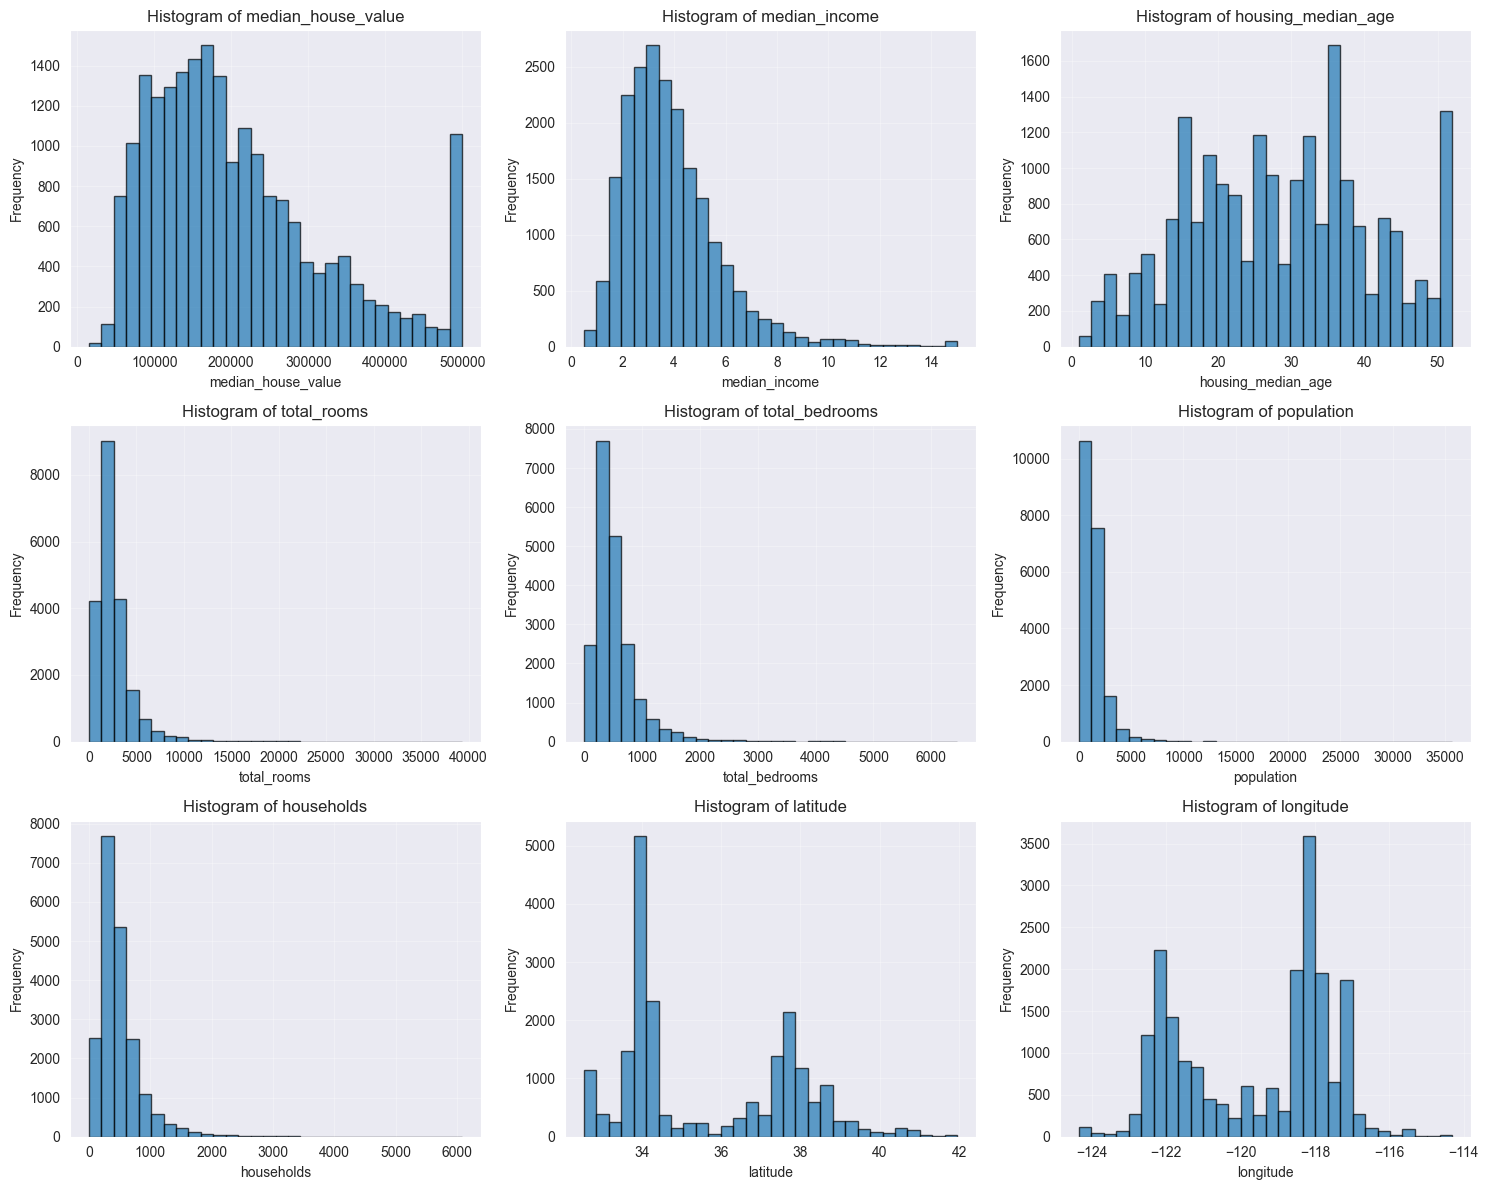

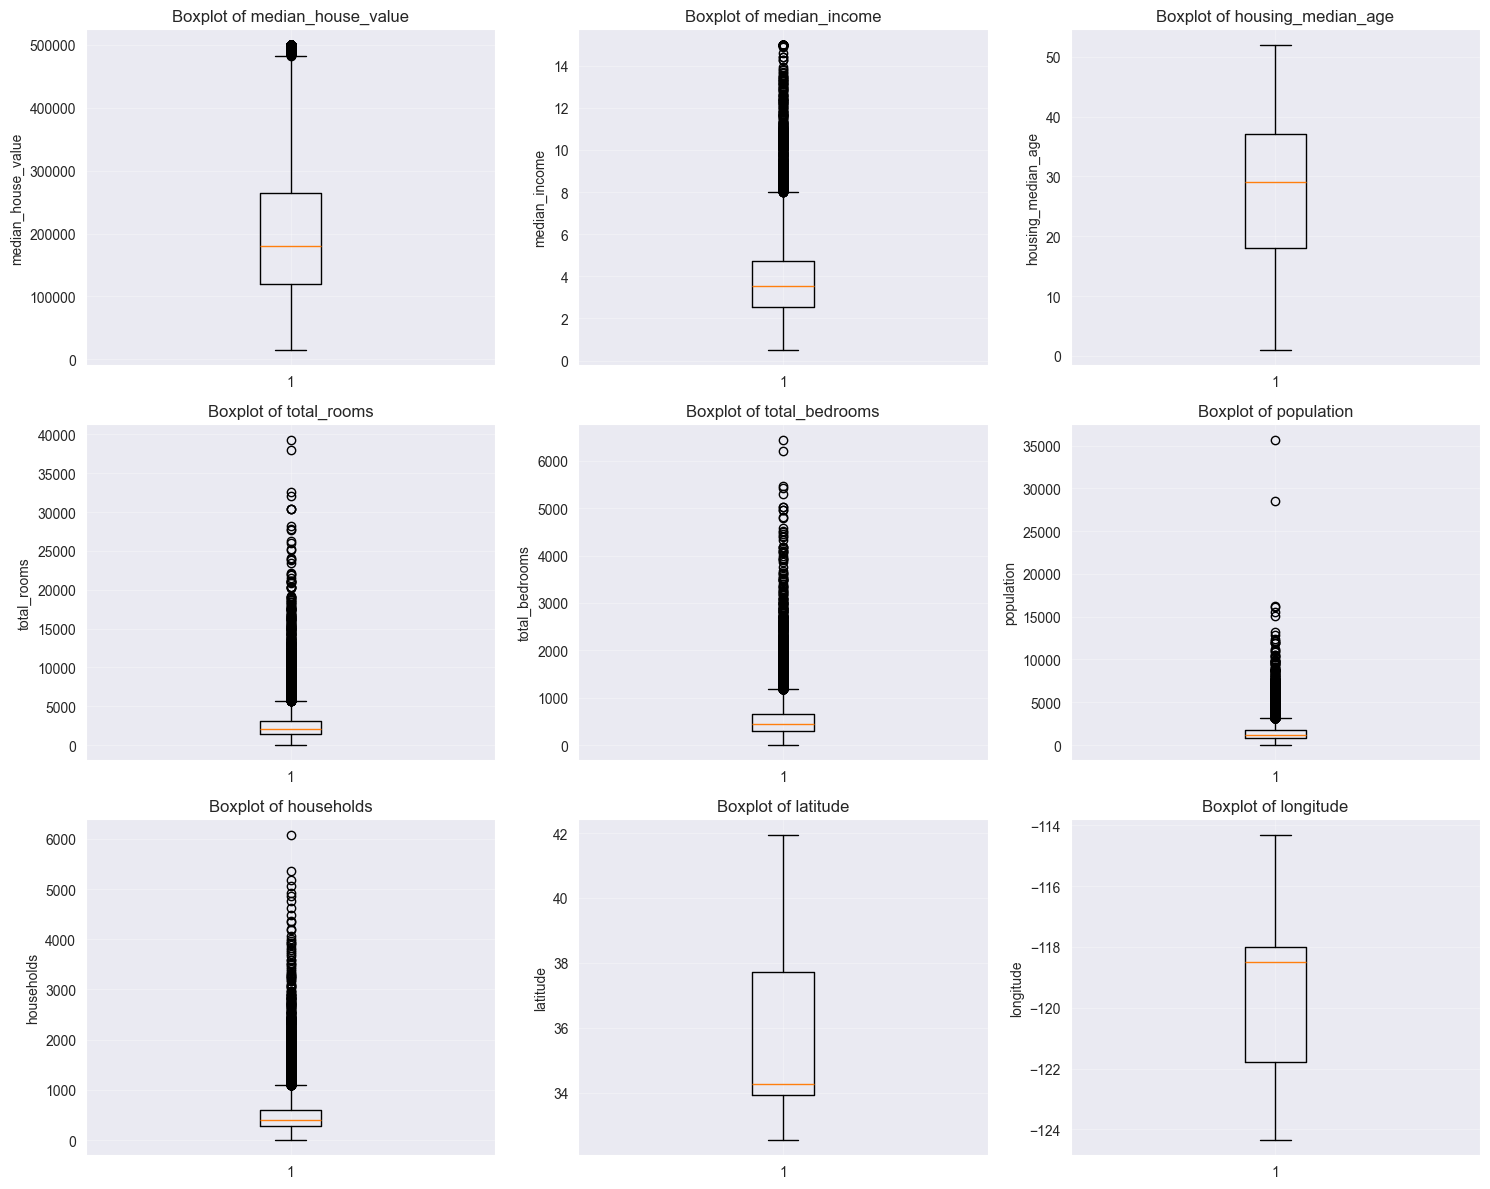

In [8]:
import matplotlib.pyplot as plt

# Get numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Create subplots for histograms
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    if idx < len(axes):
        axes[idx].hist(data[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Histogram of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)

# Hide any unused subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Create boxplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    if idx < len(axes):
        axes[idx].boxplot(data[col].dropna(), vert=True)
        axes[idx].set_title(f'Boxplot of {col}')
        axes[idx].set_ylabel(col)
        axes[idx].grid(True, alpha=0.3)

# Hide any unused subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


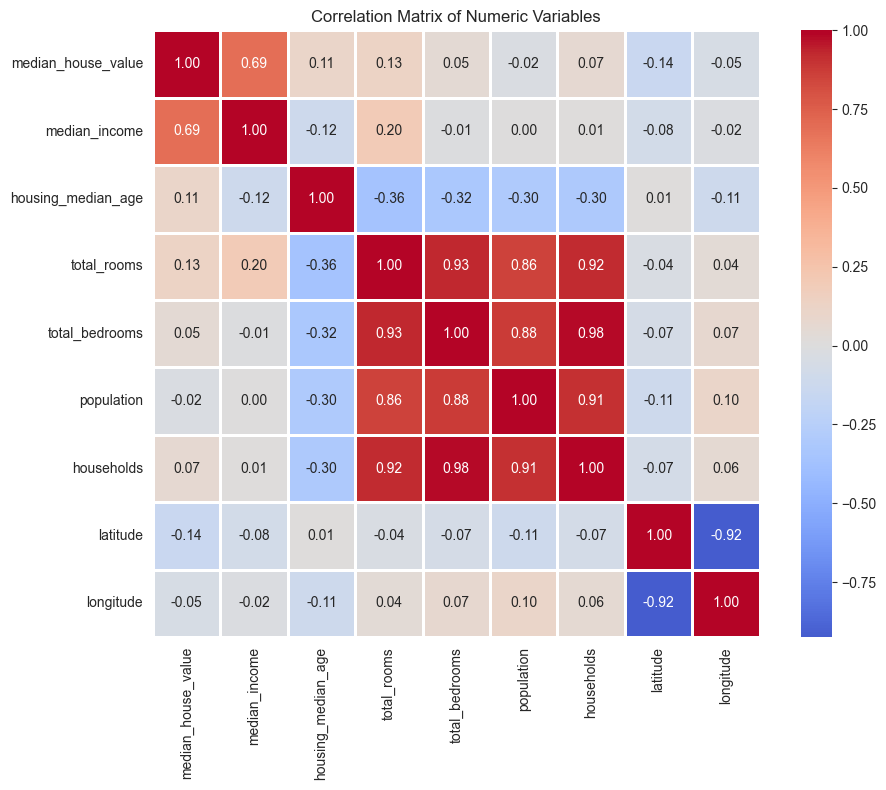

In [9]:
# Correlation matrix
import seaborn as sns

correlation_matrix = data[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=1)
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()


My goal will be to predict the median house value depending on other variables about the house.
Evaluation metrics:
1) MSE (Mean Squared Error) - Target to minimize. alternative could be MAE

## Data Preparation for MLP Model

Performing data normalization, train/validation/test split, and MLP configuration for predicting median house value.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Keep ONLY these 5 features as predictors based on correlations with target
feature_cols = ["median_income", "housing_median_age", "total_rooms", "latitude", "longitude"]
target_col = "median_house_value"

data = data[feature_cols + [target_col]].dropna()  # drop rows with missing values (shouldnt be any)

X = data[feature_cols]
y = data[target_col]

# First split off 10% for test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
# Then split the remaining 90% into ~70% train and ~20% val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.22, random_state=42)

print(f"Training set size:   {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size:       {X_test.shape[0]}")




Training set size:   14489
Validation set size: 4087
Test set size:       2064


In [11]:
import numpy as np
# NORMALIZATION using StandardScaler
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_val_scaled   = x_scaler.transform(X_val)
X_test_scaled  = x_scaler.transform(X_test)

# Normalize target variable
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_val_scaled   = y_scaler.transform(y_val.values.reshape(-1, 1)).astype(np.float32)
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)

print("Data normalization completed")
print("Feature shape:", X_train_scaled.shape)


Data normalization completed
Feature shape: (14489, 5)


In [12]:
# !pip install torch

In [13]:
import torch
import random
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
#Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# =====Convert to PyTorch tensors & simple DataLoaders =====
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)  # shape (N, 1)

X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val_scaled,   dtype=torch.float32)

X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test_scaled,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)

# WE START with relatively simple simple MLP. Since 5 predictors =====
# Option for Droupout and Batchnorm (in later sections)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=(64, 32), output_size=1,
                 dropout_rate=0.0, use_batchnorm=False):
        super().__init__()
        layers = []
        prev = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:#ENABLING OPTION FOR Normalization layer
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout_rate > 0:# ENABLING OPTION FOR DROPOUT layer
                layers.append(nn.Dropout(dropout_rate))
            prev = h
        layers.append(nn.Linear(prev, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train_t.shape[1]  #
demo_model = MLP(input_size=input_size, hidden_sizes=(64, 32), output_size=1).to(device)

print(input_size)
print("\nMLP Architecture:")
print(demo_model)

5

MLP Architecture:
MLP(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [14]:
#-----Loss & Optimizer not now=====
#MSE
# criterion = nn.MSELoss()
# # Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#learning rate 0.001

In [15]:
#Evaluation function. and Cost function results
def evaluate(model, criterion, loader, device):
    """Compute MSE on a dataloader for the GIVEN model."""
    model.eval()
    mse_sum, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            mse_sum += criterion(preds, yb).item() * xb.size(0)
            n += xb.size(0)
    return mse_sum / n

#Report metrics in REAL dollars (MAE, RMSE )=====
def rmse_mae_in_dollars(model, X_tensor, y_scaled_tensor, y_scaler):
    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_tensor.to(device)).cpu().numpy()
    # Undo scaling to get prices in original units
    preds = y_scaler.inverse_transform(preds_scaled)
    y_true = y_scaler.inverse_transform(y_scaled_tensor.cpu().numpy())

    rmse = np.sqrt(np.mean((preds - y_true) ** 2))
    mae  = np.mean(np.abs(preds - y_true))
    return float(rmse), float(mae)

### Experiment Tracking


In [16]:
def make_tensors_for_experiment(
    X_train_raw, X_val_raw, X_test_raw,
    y_train_raw, y_val_raw, y_test_raw,
    log_total_rooms=False,
    feature_cols=("median_income","housing_median_age","total_rooms","latitude","longitude")
):
    """
    Applies optional log1p transform to total_rooms (because the distribution looks logarithmic)
    then fits StandardScaler on TRAIN only, and returns tensors + target scaler.
    """
    Xtr = X_train_raw.copy()
    Xv  = X_val_raw.copy()
    Xte = X_test_raw.copy()

    # map columns to indices
    col_to_idx = {c: i for i, c in enumerate(feature_cols)}

    if log_total_rooms:
        i = col_to_idx["total_rooms"]
        Xtr[:, i] = np.log1p(Xtr[:, i]); Xv[:, i] = np.log1p(Xv[:, i]); Xte[:, i] = np.log1p(Xte[:, i])


    # Scale on TRAIN only
    x_scaler = StandardScaler()
    Xtr_s = x_scaler.fit_transform(Xtr)
    Xv_s  = x_scaler.transform(Xv)
    Xte_s = x_scaler.transform(Xte)

    y_scaler = StandardScaler()
    ytr_s = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).astype(np.float32)
    yv_s  = y_scaler.transform(y_val_raw.reshape(-1, 1)).astype(np.float32)
    yte_s = y_scaler.transform(y_test_raw.reshape(-1, 1)).astype(np.float32)

    # To tensors
    Xtr_t = torch.tensor(Xtr_s, dtype=torch.float32)
    Xv_t  = torch.tensor(Xv_s,  dtype=torch.float32)
    Xte_t = torch.tensor(Xte_s, dtype=torch.float32)
    ytr_t = torch.tensor(ytr_s, dtype=torch.float32)
    yv_t  = torch.tensor(yv_s,  dtype=torch.float32)
    yte_t = torch.tensor(yte_s, dtype=torch.float32)

    return Xtr_t, Xv_t, Xte_t, ytr_t, yv_t, yte_t, y_scaler


In [17]:
def train_one_config(
    model_cfg, train_cfg, transforms_cfg,
    X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np, device,seed_torch=None
):
    """
    Trains once with the provided configs and returns metrics.
    model_cfg: dict with hidden_sizes, dropout
    train_cfg: dict with epochs, lr, batch_size, weight_decay, patience
    transforms_cfg: dict with log_total_rooms
    """
    # Reproducibility
    if seed_torch is not None:
        torch.manual_seed(seed_torch)
        torch.cuda.manual_seed_all(seed_torch)
    Xtr_t, Xv_t, Xte_t, ytr_t, yv_t, yte_t, y_scaler = make_tensors_for_experiment(
        X_train_np, X_val_np, X_test_np,
        y_train_np, y_val_np, y_test_np,
        log_total_rooms=transforms_cfg.get("log_total_rooms", False),
    )

    # Datasets / loaders
    train_ds = TensorDataset(Xtr_t, ytr_t)
    val_ds   = TensorDataset(Xv_t,  yv_t)
    train_loader = DataLoader(train_ds, batch_size=train_cfg.get("batch_size", 64), shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)

    # Model, loss, optimizer
    model = MLP(
        input_size=Xtr_t.shape[1],
        hidden_sizes=tuple(model_cfg.get("hidden_sizes", (64, 32))),
        output_size=1,
        dropout_rate=model_cfg.get("dropout", 0.0),  #
        use_batchnorm=model_cfg.get("use_batchnorm", False),
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=train_cfg.get("lr", 1e-3),
        weight_decay=train_cfg.get("weight_decay", 0.0)
    )

    # Simple early stopping
    epochs   = train_cfg.get("epochs", 100)
    patience = train_cfg.get("patience", 15)# we WAIT until 15 epochs to determine the effect
    best_val = float("inf")
    best_state = None
    best_epoch = 0
    no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        val_mse = evaluate(model, criterion, val_loader, device)#evaluate() from before that returns MSE on *scaled* target

        if val_mse < best_val - 1e-5:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            no_improve = 0
        else:
            no_improve += 1

        #print every 20 epochs
        if epoch % 20 == 0 or epoch == 1:
            print(f"[{train_cfg.get('name','run')}] Epoch {epoch:3d}  val_MSE_scaled={val_mse:.4f}")

        if no_improve >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    # Metrics in dollars

    val_rmse, val_mae = rmse_mae_in_dollars(model, Xv_t, yv_t, y_scaler)
    return {
        "val_RMSE_$": float(val_rmse),
        "val_MAE_$": float(val_mae),
        "best_epoch": int(best_epoch),
    }


In [18]:
import time
def run_experiments_return_df(
    X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np, device
):
    """
    Defines a baseline config and then runs several single-change experiments.
    Returns pandas DataFrame with comparisons.
    """
    # ---- Baseline & Experiments (CONFIG-driven) ----

    if 'CONFIG' in globals() and isinstance(CONFIG.get('experiments', None), list) and len(CONFIG['experiments']) > 0:
        _cfg_exps = CONFIG['experiments']
        # Find baseline entry by name, otherwise default to the first entry.
        _baseline_idx = 0
        for _i, _exp in enumerate(_cfg_exps):
            if str(_exp.get('name', '')).lower() == 'baseline':
                _baseline_idx = _i
                break
        _baseline = _cfg_exps[_baseline_idx]

        # Convert hidden_sizes lists to tuples (as the model expects tuples)
        def _as_tuple_sizes(m):
            if 'hidden_sizes' in m and isinstance(m['hidden_sizes'], list):
                m = {**m, 'hidden_sizes': tuple(m['hidden_sizes'])}
            return m

        base_model = _as_tuple_sizes(dict(**_baseline.get('model', {})))
        base_train = dict(**_baseline.get('train', {}))
        base_tfms  = dict(**_baseline.get('tfm', {}))

        # Build exps as list of (name, model, train, tfm)
        exps = []
        for _exp in _cfg_exps:
            _m = _as_tuple_sizes(base_model | _exp.get('model', {}))
            _t = base_train | _exp.get('train', {})
            _f = base_tfms | _exp.get('tfm', {})
            exps.append((_exp.get('name', 'exp'), _m, _t, _f))
    else:
        # Fallback to original hard-coded set (unchanged from your notebook)
        base_model = dict(hidden_sizes=(64, 32), dropout=0.0)  #no dropout
        base_train = dict(name="baseline", epochs=100, lr=1e-3, batch_size=64, weight_decay=0.0, patience=15)
        base_tfms = dict(log_total_rooms=False)
        exps = [
            ("baseline", base_model, base_train, base_tfms),
            ("epochs_x2",  base_model, {**base_train, "name": "epochs_x2", "epochs": 200}, base_tfms),
            ("log1p_total_rooms", base_model, {**base_train, "name": "log1p_total_rooms"}, {**base_tfms, "log_total_rooms": True}),
            ("batch_32",  base_model, {**base_train, "name": "batch_32", "batch_size": 32}, base_tfms),
            ("dropout_0p2", {**base_model, "dropout": 0.2}, {**base_train, "name": "dropout_0p2"}, base_tfms),
            ("dropout_0p1", {**base_model, "dropout": 0.1}, {**base_train, "name": "dropout_0p1"}, base_tfms),
            ("lr_3e-4", base_model, {**base_train, "name": "lr_3e-4", "lr": 3e-4}, base_tfms),
            ("hidden_128_64", {**base_model, "hidden_sizes": (128, 64)}, {**base_train, "name": "hidden_128_64"}, base_tfms),
            ("weight_decay_1e-4", base_model, {**base_train, "name": "weight_decay_1e-4", "weight_decay": 1e-4}, base_tfms),
            ("batchnorm", {**base_model, "use_batchnorm": True}, {**base_train, "name": "batchnorm"}, base_tfms),
        ]

# ---- Run and record ----
    rows = []
    # Keep a copy of the *values* in the baseline to compute "changed_param"
    baseline_knobs = dict(
        **{f"model.{k}": v for k, v in base_model.items()},
        **{f"train.{k}": v for k, v in base_train.items()},
        **{f"tfm.{k}": v for k, v in base_tfms.items()},
    )

    for name, m_cfg, t_cfg, tf_cfg in exps:
        start = time.time()
        res = train_one_config(m_cfg, t_cfg, tf_cfg,
                               X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np, device)
        elapsed = time.time() - start

        # identify which single param changed (by design, exactly one)
        current_knobs = dict(
            **{f"model.{k}": v for k, v in m_cfg.items()},
            **{f"train.{k}": v for k, v in t_cfg.items()},
            **{f"tfm.{k}": v for k, v in tf_cfg.items()},
        )
        IGNORE_KEYS = {"train.name"}
        changed = [(k, baseline_knobs[k], current_knobs[k])
           for k in baseline_knobs.keys()
           if baseline_knobs[k] != current_knobs[k]and (k not in IGNORE_KEYS)]
        if name == "baseline":  # nothing should differ
            changed_param = "—"; base_val = "—"; new_val = "—"
        elif len(changed) == 1:
            k, b, v = changed[0]
            changed_param = k
            base_val = str(b)
            new_val = str(v)
        else:
            # In case more than one differs (shouldn’t happen ...)
            changed_param = ",".join([c[0] for c in changed]) if changed else "—"
            base_val = "various"
            new_val = "various"

        rows.append(dict(
            experiment=name,
            changed_param=changed_param,
            baseline_value=base_val,
            new_value=new_val,
            val_RMSE=res["val_RMSE_$"],
            val_MAE=res["val_MAE_$"],
            best_epoch=res["best_epoch"],
            seconds=round(elapsed, 2),
        ))

    # Tidy DataFrame (baseline first, others sorted by RMSE)
    df = pd.DataFrame(rows)
    baseline_first = df[df["experiment"] == "baseline"]
    others_sorted = df[df["experiment"] != "baseline"].sort_values("val_RMSE", ascending=True)
    df_out = pd.concat([baseline_first, others_sorted], ignore_index=True)

    # Save
    df_out.to_csv("experiment_results.csv", index=False)
    return df_out

### Run THE Experiments


In [19]:
feature_cols = ["median_income", "housing_median_age", "total_rooms", "latitude", "longitude"]
X_train_np = X_train[feature_cols].values
X_val_np   = X_val[feature_cols].values
X_test_np  = X_test[feature_cols].values
y_train_np = y_train.values
y_val_np   = y_val.values
y_test_np  = y_test.values

summary_df = run_experiments_return_df(
    X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np, device
)
baseline_rmse = summary_df.loc[summary_df["experiment"]=="baseline", "val_RMSE"].iloc[0]
summary_df["Δ_RMSE"] = summary_df["val_RMSE"] - baseline_rmse
summary_df["%_change"] = 100.0 * (summary_df["val_RMSE"]/baseline_rmse - 1.0)
summary_df.sort_values("val_RMSE", inplace=True)
print("Done")
# print("\n=== Experiment summary (top = baseline; others sorted by best RMSE) ===")
# print(summary_df.head(20))

[baseline] Epoch   1  val_MSE_scaled=0.3706
[baseline] Epoch  20  val_MSE_scaled=0.3000
[baseline] Epoch  40  val_MSE_scaled=0.2763
[baseline] Epoch  60  val_MSE_scaled=0.2716
[epochs_x2] Epoch   1  val_MSE_scaled=0.3661
[epochs_x2] Epoch  20  val_MSE_scaled=0.2966
[epochs_x2] Epoch  40  val_MSE_scaled=0.2834
[epochs_x2] Epoch  60  val_MSE_scaled=0.2715
[epochs_x2] Epoch  80  val_MSE_scaled=0.2693
[epochs_x2] Epoch 100  val_MSE_scaled=0.2644
[epochs_x2] Epoch 120  val_MSE_scaled=0.2490
[log1p_total_rooms] Epoch   1  val_MSE_scaled=0.3646
[log1p_total_rooms] Epoch  20  val_MSE_scaled=0.2831
[log1p_total_rooms] Epoch  40  val_MSE_scaled=0.2869
[log1p_total_rooms] Epoch  60  val_MSE_scaled=0.2650
[log1p_total_rooms] Epoch  80  val_MSE_scaled=0.2609
[log1p_total_rooms] Epoch 100  val_MSE_scaled=0.2565
[batch_32] Epoch   1  val_MSE_scaled=0.3536
[batch_32] Epoch  20  val_MSE_scaled=0.2904
[batch_32] Epoch  40  val_MSE_scaled=0.2723
[batch_32] Epoch  60  val_MSE_scaled=0.2534
[batch_32] Epoc

In [20]:
print("\n=== Experiment summary (top = baseline; others sorted by best RMSE) ===")
summary_df


=== Experiment summary (top = baseline; others sorted by best RMSE) ===


,experiment,changed_param,baseline_value,new_value,val_RMSE,val_MAE,best_epoch,seconds,Δ_RMSE,%_change
1,batch_32,train.batch_size,64,32,56146.933594,38396.320312,100,62.63,-3899.437500,-6.494044
2,hidden_128_64,model.hidden_sizes,"(64, 32)","(128, 64)",56246.734375,38983.382812,95,39.28,-3799.636719,-6.327837
3,log1p_total_rooms,tfm.log_total_rooms,False,True,57387.605469,39492.917969,98,39.01,-2658.765625,-4.427854
4,epochs_x2,train.epochs,100,200,57922.464844,40413.140625,120,52.91,-2123.906250,-3.537110
5,dropout_0p1,model.dropout,0.0,0.1,58052.597656,39946.382812,95,52.31,-1993.773438,-3.320390
6,weight_decay_1e-4,train.weight_decay,0.0,0.0001,59684.570312,41308.484375,92,39.10,-361.800781,-0.602536
0,baseline,—,—,—,60046.371094,41877.640625,62,34.26,0.000000,0.000000
7,batchnorm,—,various,various,60965.699219,42100.363281,72,45.21,919.328125,1.531030
8,dropout_0p2,model.dropout,0.0,0.2,61042.984375,42237.636719,96,42.80,996.613281,1.659739
9,lr_3e-4,train.lr,0.001,0.0003,61501.511719,42206.652344,94,33.50,1455.140625,2.423361


## Conclusions from Single‑Change Experiments

Using the baseline (val_RMSE = **60,046**):
(**Improvements**:

- **batch_32** → **56146** ( **−6.49%**)- strongest single change
- **hidden_128_64** → **56246** (**−6.32%**) - equally beneficial
- **log1p_total_rooms** → **57387** ( **−4.43%**) - Log transform helps
- **epochs_x2 (200)** → **57922** (**−3.53%**)


- **weight_decay_1e-4** →  +-0.6% -doesn't help much
- **dropout_0p2** →  just 5 features, model is rather underfitting, dropout might not be needed, or small 
- **lr_3e-4** →  +2.42% - too slow for current schedule

**conclusion:**
-  Larger **hidden sizes (128,64)**,Bigger **epochs_x2 (200)** , Smaller **batch size (32)**, and `log1p(total_rooms)` are the most promising improvements.
- **BatchNorm**  doesn't look mandatory.
- Big **Dropout** and **lower LR** hurt here → we’ll keep dropout low, around **0.0**, LR centered around **1e‑3**.


##   Hyperparameter Search


In [21]:
 #--- Random hyperparameter search around the winners ---

import math, random

from copy import deepcopy

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


# Center - based on  best single changes
base_model = dict(
    hidden_sizes=(128, 64),
    dropout=0.0,
    use_batchnorm=False,      # BatchNorm DID not help
)
base_train = dict(
    name="rs",
    lr=1e-3,
    batch_size=32,           # fixed at 32 (best result)
    weight_decay=0.0,
    epochs=200,
    patience=20,
    min_delta=5e-4,
)
base_tfms = dict(log_total_rooms=True)  # better with being logarithmized

# ----- samplers (biased towards best results) -----
def loguniform(low, high):
    """Sample log-uniform in [low, high]."""
    return float(np.exp(np.random.uniform(np.log(low), np.log(high))))

def choice_w(weighted_items):
    """Weighted choice from list of (value, weight)."""
    vals, wts = zip(*weighted_items)
    return random.choices(vals, weights=wts, k=1)[0]

def sample_hidden_sizes():
    # 60% of the time, pick from my strong candidates; otherwise generate
    if random.random() < 0.60:
        return random.choice([(128, 64), (128, 32), (256, 128, 64)])
    # lightweight generator around typical widths/depths
    depth = choice_w([(2, 0.7), (3, 0.3)])
    first = choice_w([(96, 1.0), (128, 3.0), (160, 1.5), (192, 1.0), (256, 1.5)])
    sizes = [int(first)]
    if depth >= 2:
        second = choice_w([(32, 0.6), (64, 2.5), (96, 1.5), (128, 1.4)])
        sizes.append(int(second))
    if depth == 3:
        third = choice_w([(32, 1.5), (64, 2.0), (96, 1.0)])
        sizes.append(int(third))
    return tuple(sizes)

def sample_trial(i):
    # LR: focus on 5e-4..2e-3; occasionally explore wider
    lr = loguniform(5e-4, 2e-3)
    if random.random() < 0.10:
        lr = loguniform(1e-4, 5e-3)

    # WD: 65% chance of 0 (since nonzero was slightly helpful), else loguniform
    wd = 0.0 if random.random() < 0.50 else loguniform(1e-6, 3e-4)

    # Dropout: bias to small values; cap to [0, 0.3]
    if random.random() < 0.70:
        dr = 0.0
    else:
        dr = float(np.clip(np.random.normal(0.08, 0.05), 0.0, 0.30))

    # BatchNorm: bias towards False given the gains
    bn = False if random.random() < 0.70 else True

    h = sample_hidden_sizes()

    return dict(
        name=f"rs_{i}",
        hidden_sizes=h,
        lr=lr,
        weight_decay=wd,
        dropout=dr,
        use_batchnorm=bn,
    )

# ----- search loop -----
if 'CONFIG' in globals():
    N_TRIALS = CONFIG.get("hyperparam_search", {}).get("n_trials", 30)
else:
    N_TRIALS = 30
rows = []
best_rmse = math.inf
best_row = None

for i in range(1, N_TRIALS + 1):
    p = sample_trial(i)

    model_cfg = deepcopy(base_model)
    model_cfg.update(
        dict(
            hidden_sizes=p["hidden_sizes"],
            dropout=p["dropout"],
            use_batchnorm=p["use_batchnorm"],
        )
    )

    train_cfg = deepcopy(base_train)
    train_cfg.update(
        dict(
            lr=p["lr"],
            weight_decay=p["weight_decay"],
            name=p["name"],
        )
    )

    print(
        f"\n=== Trial {i}/{N_TRIALS}: "
        f"hidden={p['hidden_sizes']}, lr={p['lr']:.2e}, wd={p['weight_decay']:.2e}, "
        f"dropout={p['dropout']:.2f}, BN={p['use_batchnorm']} ==="
    )

    try:
        res = train_one_config(
            model_cfg, train_cfg, base_tfms,
            X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np, device, seed_torch=SEED + i
        )
    except Exception as e:
        print(f"Trial {i} failed with error: {e}")
        continue

    # merge configs into result row for analysis
    res.update(
        dict(
            hidden_sizes=p["hidden_sizes"],
            lr=p["lr"],
            weight_decay=p["weight_decay"],
            dropout=p["dropout"],
            use_batchnorm=p["use_batchnorm"],
            trial=i,
        )
    )
    rows.append(res)

    # live best tracking
    val_rmse = res.get("val_RMSE_$", float("inf"))
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_row = res
        print(
            f"NEW BEST at trial {i}: val_RMSE={val_rmse:.3f} | "
            f"hidden={p['hidden_sizes']}, lr={p['lr']:.2e}, wd={p['weight_decay']:.2e}, "
            f"dropout={p['dropout']:.2f}, BN={p['use_batchnorm']}"
        )

# ----- results table -----
search_df = pd.DataFrame(rows)
if not search_df.empty:
    sort_col = "val_RMSE_$" if "val_RMSE_$" in search_df.columns else "val_RMSE"
    search_df = search_df.sort_values(sort_col, ascending=True).reset_index(drop=True)

    print("\nTop-1 config:")
    if best_row is not None:
        print({k: best_row[k] for k in ["hidden_sizes", "lr", "weight_decay", "dropout", "use_batchnorm", "val_RMSE", "val_MAE", "best_epoch"] if k in best_row})

else:
    print("No successful trials to display.")


=== Trial 1/30: hidden=(256, 32), lr=8.40e-04, wd=0.00e+00, dropout=0.00, BN=False ===
[rs_1] Epoch   1  val_MSE_scaled=0.3442
[rs_1] Epoch  20  val_MSE_scaled=0.2969
[rs_1] Epoch  40  val_MSE_scaled=0.2771
[rs_1] Epoch  60  val_MSE_scaled=0.2583
[rs_1] Epoch  80  val_MSE_scaled=0.2406
[rs_1] Epoch 100  val_MSE_scaled=0.2281
[rs_1] Epoch 120  val_MSE_scaled=0.2200
[rs_1] Epoch 140  val_MSE_scaled=0.2262
NEW BEST at trial 1: val_RMSE=54452.680 | hidden=(256, 32), lr=8.40e-04, wd=0.00e+00, dropout=0.00, BN=False

=== Trial 2/30: hidden=(128, 64), lr=1.87e-03, wd=0.00e+00, dropout=0.00, BN=False ===
[rs_2] Epoch   1  val_MSE_scaled=0.3519
[rs_2] Epoch  20  val_MSE_scaled=0.2780
[rs_2] Epoch  40  val_MSE_scaled=0.2473
[rs_2] Epoch  60  val_MSE_scaled=0.2339
[rs_2] Epoch  80  val_MSE_scaled=0.2282
[rs_2] Epoch 100  val_MSE_scaled=0.2348
[rs_2] Epoch 120  val_MSE_scaled=0.2126
[rs_2] Epoch 140  val_MSE_scaled=0.2230
NEW BEST at trial 2: val_RMSE=53523.695 | hidden=(128, 64), lr=1.87e-03, wd

In [22]:
display(search_df.head(10))

,val_RMSE_$,val_MAE_$,best_epoch,hidden_sizes,lr,weight_decay,dropout,use_batchnorm,trial
0,52444.882812,35168.054688,84,"(256, 128, 64)",0.000524,0.00000,0.000000,False,29
1,52572.339844,35522.148438,72,"(256, 128, 64)",0.000749,0.00000,0.000000,False,12
2,52619.476562,35326.234375,72,"(128, 96, 64)",0.001137,0.00000,0.000000,False,19
3,52829.812500,35151.480469,48,"(256, 128, 64)",0.001291,0.00000,0.000000,False,26
4,52902.394531,35632.433594,151,"(256, 128, 64)",0.000542,0.00014,0.158961,False,6
5,53011.101562,35070.343750,95,"(256, 128, 64)",0.000643,0.00000,0.000000,False,9
6,53162.140625,35857.941406,68,"(256, 128, 64)",0.000831,0.00000,0.000000,False,16
7,53179.687500,36220.648438,80,"(128, 64, 64)",0.000633,0.00000,0.000000,False,21
8,53261.867188,36116.062500,82,"(256, 128, 64)",0.001020,0.00000,0.000000,False,18
9,53275.855469,36040.875000,131,"(128, 64)",0.001379,0.00003,0.000000,False,3


### FINAL evaluation with test set

## Load Best Checkpoint and Evaluate on Test Set

In [23]:
# Get best hyperparameters from search
best_config = search_df.iloc[0]

print("Best configuration:")
print(f"Hidden sizes: {best_config['hidden_sizes']}")
print(f"Learning rate: {best_config['lr']:.2e}")
print(f"Weight decay: {best_config['weight_decay']:.2e}")
print(f"Dropout: {best_config['dropout']:.3f}")
print(f"BatchNorm: {best_config['use_batchnorm']}")
print(f"Validation RMSE: ${best_config['val_RMSE_$']:,.2f}")

Best configuration:
Hidden sizes: (256, 128, 64)
Learning rate: 5.24e-04
Weight decay: 0.00e+00
Dropout: 0.000
BatchNorm: False
Validation RMSE: $52,444.88


In [24]:
# Prepare data with best transforms (log_total_rooms=True)
Xtr_t, Xv_t, Xte_t, ytr_t, yv_t, yte_t, y_scaler = make_tensors_for_experiment(
    X_train_np, X_val_np, X_test_np,
    y_train_np, y_val_np, y_test_np,
    log_total_rooms=True
)

In [25]:
# Train final model with best hyperparameters on train+val
X_train_val = np.vstack([X_train_np, X_val_np])
y_train_val = np.concatenate([y_train_np, y_val_np])

# Apply log transform
X_tv = X_train_val.copy()
col_to_idx = {c: i for i, c in enumerate(feature_cols)}
i = col_to_idx["total_rooms"]
X_tv[:, i] = np.log1p(X_tv[:, i])
Xte_final = X_test_np.copy()
Xte_final[:, i] = np.log1p(Xte_final[:, i])

# Scale
x_scaler_final = StandardScaler()
X_tv_scaled = x_scaler_final.fit_transform(X_tv)
Xte_scaled = x_scaler_final.transform(Xte_final)

y_scaler_final = StandardScaler()
y_tv_scaled = y_scaler_final.fit_transform(y_train_val.reshape(-1, 1)).astype(np.float32)
yte_scaled = y_scaler_final.transform(y_test_np.reshape(-1, 1)).astype(np.float32)

# Convert to tensors
X_tv_t = torch.tensor(X_tv_scaled, dtype=torch.float32)
y_tv_t = torch.tensor(y_tv_scaled, dtype=torch.float32)
Xte_t = torch.tensor(Xte_scaled, dtype=torch.float32)
yte_t = torch.tensor(yte_scaled, dtype=torch.float32)

train_val_ds = TensorDataset(X_tv_t, y_tv_t)
train_val_loader = DataLoader(train_val_ds, batch_size=32, shuffle=True)

In [26]:
# Build final model with best hyperparameters
final_model = MLP(
    input_size=X_tv_t.shape[1],
    hidden_sizes=best_config['hidden_sizes'],
    output_size=1,
    dropout_rate=best_config['dropout'],
    use_batchnorm=best_config['use_batchnorm']
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    final_model.parameters(),
    lr=best_config['lr'],
    weight_decay=best_config['weight_decay']
)

print(f"\nTraining final model on {len(X_tv_t)} samples (train+val)...")


Training final model on 18576 samples (train+val)...


In [27]:
# Train final model
epochs = 200
for epoch in range(1, epochs + 1):
    final_model.train()
    for xb, yb in train_val_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
        final_model.eval()
        with torch.no_grad():
            train_preds = final_model(X_tv_t.to(device))
            train_loss = criterion(train_preds, y_tv_t.to(device)).item()
        print(f"Epoch {epoch:3d}  train_loss={train_loss:.4f}")

print("Training completed!")

Epoch   1  train_loss=0.3457
Epoch  20  train_loss=0.2501
Epoch  40  train_loss=0.1996
Epoch  60  train_loss=0.1740
Epoch  80  train_loss=0.1608
Epoch 100  train_loss=0.1477
Epoch 120  train_loss=0.1434
Epoch 140  train_loss=0.1288
Epoch 160  train_loss=0.1227
Epoch 180  train_loss=0.1179
Epoch 200  train_loss=0.1140
Training completed!


In [28]:
# Evaluate on test set
final_model.eval()
with torch.no_grad():
    test_preds_scaled = final_model(Xte_t.to(device)).cpu().numpy()

# Convert back to original scale
test_preds = y_scaler_final.inverse_transform(test_preds_scaled)
y_test_actual = y_scaler_final.inverse_transform(yte_t.cpu().numpy())

# Calculate metrics
test_rmse = np.sqrt(np.mean((test_preds - y_test_actual) ** 2))
test_mae = np.mean(np.abs(test_preds - y_test_actual))
test_mse = np.mean((test_preds - y_test_actual) ** 2)

print("\n" + "=" * 60)
print("FINAL TEST SET EVALUATION")
print("=" * 60)
print(f"Test RMSE: ${test_rmse:,.2f}")
print(f"Test MAE:  ${test_mae:,.2f}")
print(f"Test MSE:  ${test_mse:,.2f}")
print("=" * 60)


FINAL TEST SET EVALUATION
Test RMSE: $56,851.15
Test MAE:  $38,059.01
Test MSE:  $3,232,053,248.00


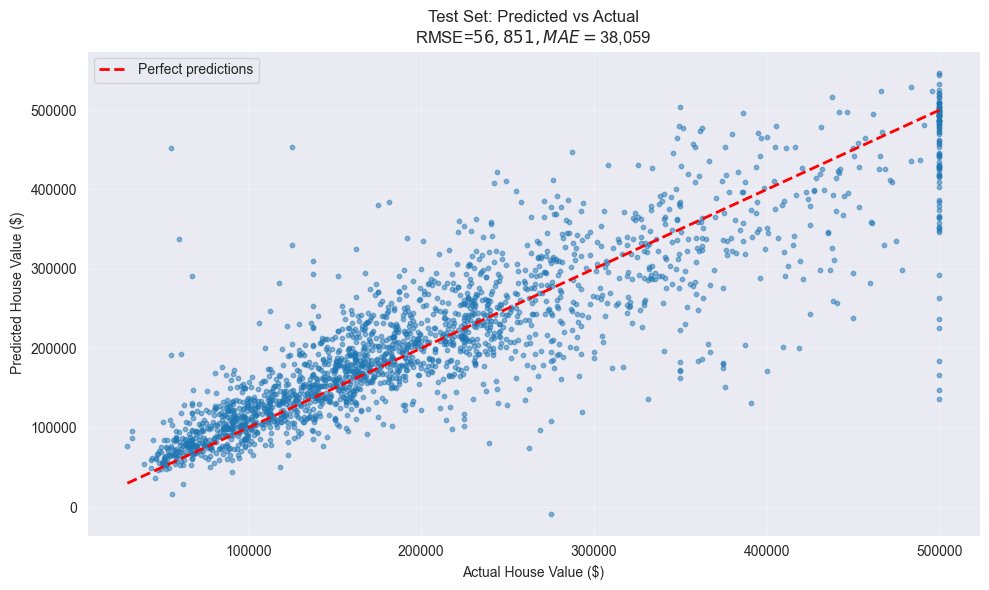

In [29]:
# Create comparison plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, test_preds, alpha=0.5, s=10)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2, label='Perfect predictions')
plt.xlabel('Actual House Value ($)')
plt.ylabel('Predicted House Value ($)')
plt.title(f'Test Set: Predicted vs Actual\nRMSE=${test_rmse:,.0f}, MAE=${test_mae:,.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

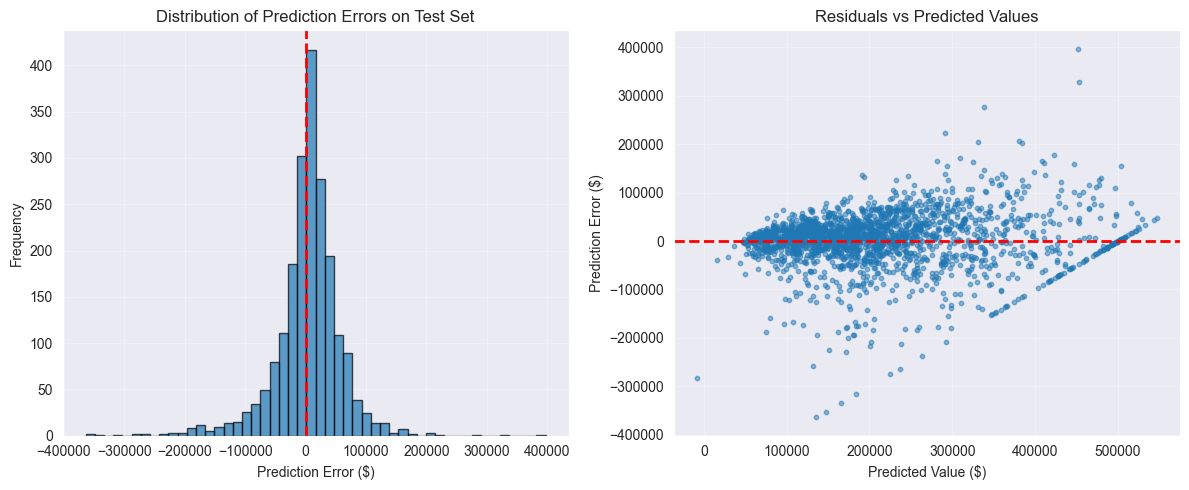

In [30]:
# Prediction errors distribution
errors = (test_preds - y_test_actual).flatten()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors on Test Set')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(test_preds, errors, alpha=0.5, s=10)
plt.xlabel('Predicted Value ($)')
plt.ylabel('Prediction Error ($)')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# show final results
final_results = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'MSE'],
    'test_value': [test_rmse, test_mae, test_mse]
})

final_results


,metric,test_value
0,RMSE,5.685115e+04
1,MAE,3.805901e+04
2,MSE,3.232053e+09


In [39]:

# === Training with History (for learning curves) ===
# This function trains an MLP and records train/val/test MSE (on *scaled* target) each epoch.
def train_with_history(
    X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np,
    model_cfg, train_cfg, transforms_cfg, device
):
    Xtr_t, Xv_t, Xte_t, ytr_t, yv_t, yte_t, y_scaler = make_tensors_for_experiment(
        X_train_np, X_val_np, X_test_np,
        y_train_np, y_val_np, y_test_np,
        log_total_rooms=transforms_cfg.get("log_total_rooms", False),
    )
    train_ds = TensorDataset(Xtr_t, ytr_t)
    val_ds   = TensorDataset(Xv_t,  yv_t)
    test_ds  = TensorDataset(Xte_t, yte_t)

    tr_loader = DataLoader(train_ds, batch_size=train_cfg.get("batch_size", 64), shuffle=True)
    va_loader = DataLoader(val_ds,   batch_size=256, shuffle=False)
    te_loader = DataLoader(test_ds,  batch_size=256, shuffle=False)

    model = MLP(
        input_size=Xtr_t.shape[1],
        hidden_sizes=tuple(model_cfg.get("hidden_sizes", (64, 32))),
        output_size=1,
        dropout_rate=model_cfg.get("dropout", 0.0),
        use_batchnorm=model_cfg.get("use_batchnorm", False),
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=train_cfg.get("lr", 1e-3),
        weight_decay=train_cfg.get("weight_decay", 0.0)
    )

    epochs = train_cfg.get("epochs", 200)
    use_es = False
    patience = model_cfg.get("early_stopping", {}).get("patience", 15)
    min_delta = model_cfg.get("early_stopping", {}).get("min_delta", 1e-5)

    hist = {"train_mse": [], "val_mse": [], "test_mse": []}
    best_val = float("inf")
    no_improve = 0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in tr_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Record losses (MSE on scaled target)
        tr_mse = evaluate(model, criterion, tr_loader, device)
        va_mse = evaluate(model, criterion, va_loader, device)
        te_mse = evaluate(model, criterion, te_loader, device)
        hist["train_mse"].append(tr_mse)
        hist["val_mse"].append(va_mse)
        hist["test_mse"].append(te_mse)

        if use_es:
            if va_mse < best_val - min_delta:
                best_val = va_mse
                no_improve = 0
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            else:
                no_improve += 1
                if no_improve >= patience:
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, hist


[Learning Curves] Using parameters:
  hidden_sizes= (256, 128, 64)
  dropout= 0.0   use_batchnorm= False
  lr= 0.0005244136133080424   weight_decay= 0.0   batch_size= 64


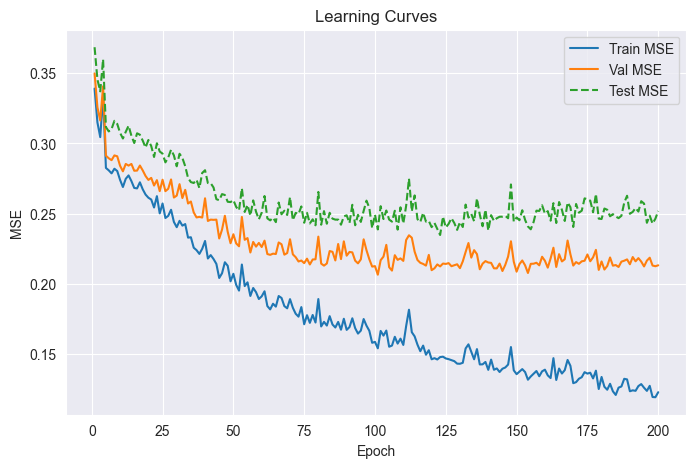

In [40]:
# === Learning Curve Run & Plots ===


# If best_config is not in scope, try to derive it from search_df
if 'best_config' not in globals() and 'search_df' in globals():
    try:
        if (hasattr(search_df, 'empty') and not search_df.empty):
            best_config = search_df.iloc[0]
    except Exception:
        pass


# Build configs from BEST hyperparameters (fallback to CONFIG if missing)
def _pick_from_best(key, default):
    try:
        if 'best_config' in globals():
            # pandas Series or dict-like support
            if hasattr(best_config, 'get'):
                val = best_config.get(key)
                if val is not None:
                    return val
            # Series-style indexing
            if hasattr(best_config, 'index') and key in getattr(best_config, 'index', []):
                return best_config[key]
            # dict-like 'in'
            if isinstance(best_config, dict) and key in best_config:
                return best_config[key]
    except Exception:
        pass
    return default

_model_cfg = {
    "hidden_sizes": _pick_from_best("hidden_sizes", CONFIG["model"]["hidden_sizes"]),
    "dropout": _pick_from_best("dropout", CONFIG["model"]["dropout"]),
    "use_batchnorm": _pick_from_best("use_batchnorm", CONFIG["model"]["use_batchnorm"]),
    "early_stopping": CONFIG["model"]["early_stopping"],
}
_train_cfg = {
    "epochs": 200,
    "batch_size": _pick_from_best("batch_size", CONFIG["model"]["batch_size"]),
    "lr": _pick_from_best("lr", CONFIG["model"]["learning_rate"]),
    "weight_decay": _pick_from_best("weight_decay", CONFIG["model"]["weight_decay"]),
}

print("[Learning Curves] Using parameters:")
print("  hidden_sizes=", _model_cfg["hidden_sizes"])
print("  dropout=", _model_cfg["dropout"], "  use_batchnorm=", _model_cfg["use_batchnorm"])
print("  lr=", _train_cfg["lr"], "  weight_decay=", _train_cfg["weight_decay"], "  batch_size=", _train_cfg["batch_size"])
_transforms_cfg = {
    "log_total_rooms": ("total_rooms" in CONFIG["data"]["log1p_features"])
}

# Prepare NumPy arrays from earlier split
X_train_np = X_train.values
X_val_np   = X_val.values
X_test_np  = X_test.values
y_train_np = y_train.values
y_val_np   = y_val.values
y_test_np  = y_test.values

# Device honoring CONFIG
_device = torch.device('cuda' if (CONFIG.get('runtime', {}).get('use_cuda_if_available', True) and torch.cuda.is_available()) else 'cpu')

# Train and collect per-epoch history
final_model_for_plots, history = train_with_history(
    X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np,
    _model_cfg, _train_cfg, _transforms_cfg, _device
)

# Plot learning curves (MSE on scaled target)
epochs_ran = range(1, len(history["train_mse"]) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_ran, history["train_mse"], label="Train MSE")
plt.plot(epochs_ran, history["val_mse"], label="Val MSE")
if CONFIG["evaluation"]["plot_test_curve"]:
    plt.plot(epochs_ran, history["test_mse"], label="Test MSE", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()



- 